### Look for bad signals

Goal: Look for power fault signals 
https://www.kaggle.com/c/vsb-power-line-fault-detection

I turned signals into a 3 phase power thingy. Let's see what we can see!


In [1]:
#Load Everything and ensure that during changes items are reloaded
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# We want to st the image size and batch size. We are making a bigger image for resnet50
imgsize=299
bs = 24

In [4]:
#import fastai.. cheat and load everything!
from fastai import *
#import fastai more specific
from fastai.vision import *
from fastai.metrics import error_rate

In [5]:
#path to the data
path = Path('/home/jd/data/vsb/')

In [6]:
# Read in the CSV metadata
csvlabels = pd.read_csv('/home/jd/data/vsb/metadata_train.csv')

In [7]:
#setup the signal_id and target to the lists
csvlabels = csvlabels[['signal_id','target']]
a=csvlabels['signal_id'].tolist()
b=[]
for i in a:
    b.append(str(i//3)+'.png')
csvlabels['signal_id']=b

In [8]:
# load the information required
pickle.dump(csvlabels, open( "/home/jd/data/vsb/csvlabels.p", "wb" ) )
df=pickle.load(open( "/home/jd/data/vsb/csvlabels.p", "rb" ) )

In [10]:
# oversample gets a larger number of test cases. You just duplicate the number of times you use a certain item. 
def oversample(df, col, target, percentage):
    ratio=df.groupby(col).size()[1]/df.groupby(col).size()[0]
    
    while percentage > ratio:
        print("ratio is "+str(ratio)+ " adding more")
        n=(df.groupby(col).size()[0])*percentage-df.groupby(col).size()[1]
        
        if n > df.groupby(col).size()[1]:
            n = df.groupby(col).size()[1]
        
        df0=df[(df[col]==target)].sample(n)
        df=pd.concat([df,df0], axis=1)
        #ratio = df.groupby(col).size()[1]/df.groupby(col).size()[0]
    
    
    print ("Sampling complete: Ratio is" + ratio) 
    return df

In [12]:
# gets a sample of the target and takes a look at it.
df0=df[(df['target']==1)].sample(525)
df=df.append(df0)
df.groupby('target').size()[1]

1050

In [14]:
### adds the labeling onto the sets by name
csvlabels=df
csvlabels['target'].count()
csvlabels.groupby('target').size()[1]/csvlabels.groupby('target').size()[0],csvlabels.groupby('target').size()[1]

(0.1282521069989007, 1050)

In [15]:
### gets the labels ready
csvlabels.to_csv('/home/jd/data/vsb/labels.csv', columns=['signal_id', 'target'], index=False)
testlabels = pd.read_csv('/home/jd/data/vsb/metadata_test.csv')

In [17]:
# testing to make sure everything looks good
testlabels[:5], len(testlabels),len(testlabels)/3

(   signal_id  id_measurement  phase
 0       8712            2904      0
 1       8713            2904      1
 2       8714            2904      2
 3       8715            2905      0
 4       8716            2905      1, 20337, 6779.0)

In [18]:
#we are combing the signals into 1 image before we take a look at it. Assigning each one to an image
a=testlabels['signal_id'].tolist()
b=[]
for i in a:
    b.append(str(i//3)+'.png')
#testlabels['signal_id']=b
testlabels['image']=b
testlabels[:9]

,signal_id,id_measurement,phase,image
0,8712,2904,0,2904.png
1,8713,2904,1,2904.png
2,8714,2904,2,2904.png
3,8715,2905,0,2905.png
4,8716,2905,1,2905.png
5,8717,2905,2,2905.png
6,8718,2906,0,2906.png
7,8719,2906,1,2906.png
8,8720,2906,2,2906.png


In [19]:
# creates an assignment for later
csvlabels.to_csv('/home/jd/data/vsb/submit/submission.csv', columns=['signal_id', 'target'], index=False)

# Training: resnet50
Provides a more accurate (but slower) model for image classification.

In [20]:
# This is the loss function requested by the competition
class MatthewsCorreff(ConfusionMatrix):
    "Compute the Matthews correlation coefficient."
    def __init__(self):
        pass
    def on_epoch_end(self, last_metrics, **kwargs):
        t_sum = self.cm.sum(dim=1)
        p_sum = self.cm.sum(dim=0)
        n_correct = torch.trace(self.cm)
        n_samples = p_sum.sum()
        cov_ytyp = n_correct * n_samples - torch.dot(t_sum, p_sum)
        cov_ypyp = n_samples ** 2 - torch.dot(p_sum, p_sum)
        cov_ytyt = n_samples ** 2 - torch.dot(t_sum, t_sum)
        return add_metrics(last_metrics, cov_ytyp / torch.sqrt(cov_ytyt * cov_ypyp))

In [21]:
# another loss function that would be similar to Matthew correlation
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, logit, target):
        target = target.float()
        max_val = (-logit).clamp(min=0)
        loss = logit - logit * target + max_val + \
               ((-max_val).exp() + (-logit - max_val).exp()).log()

        invprobs = F.logsigmoid(-logit * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        if len(loss.size())==2:
            loss = loss.sum(dim=1)
        return loss.mean()

In [22]:
# decrease the batch size even further
np.random.seed(42)

In [23]:
# path for the training data
path = Path('/home/jd/data/vsb/train')

In [25]:
# load up the data
data = ImageDataBunch.from_df(str(path), 
                              df=csvlabels, 
                              valid_pct=0.2,
                              size=imgsize,
                              num_workers=4,
                              bs = 24
                              ,test='/home/jd/data/vsb/test/'
                              ).normalize(imagenet_stats)

# Runs the learner
learn = cnn_learner(data, models.resnet50, metrics=MatthewsCorreff())

learn.loss_fn = FocalLoss()

In [26]:
# trying to free up more memory before we start ahead
gc.collect()

340

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


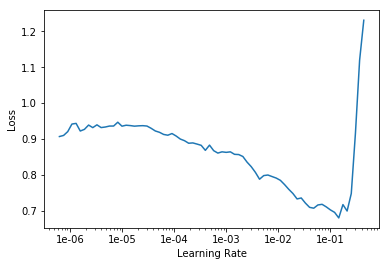

In [27]:
# find and show on plot
learn.lr_find()
learn.recorder.plot(prediction=True)

In [29]:
#unfreeze all of these. We aren't looking for eyeballs, feathers, or etc
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,matthews_correff,time
0,0.195543,0.621138,0.193943,02:05
1,0.131793,6.154078,0.306545,02:02
2,0.064228,0.030169,0.942802,02:02
3,0.029807,0.026096,0.953647,02:02


In [30]:
#Save them
learn.save('Oversampling')

## Results

In [31]:
# Lets put
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

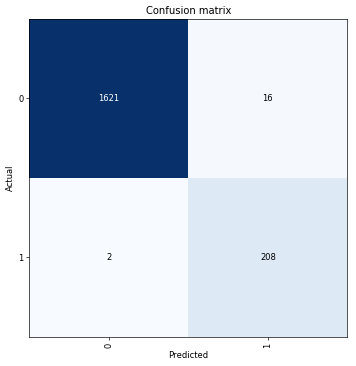

In [32]:
# See the confusion Matrix. In hindsight, I should include how many of each their are.
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

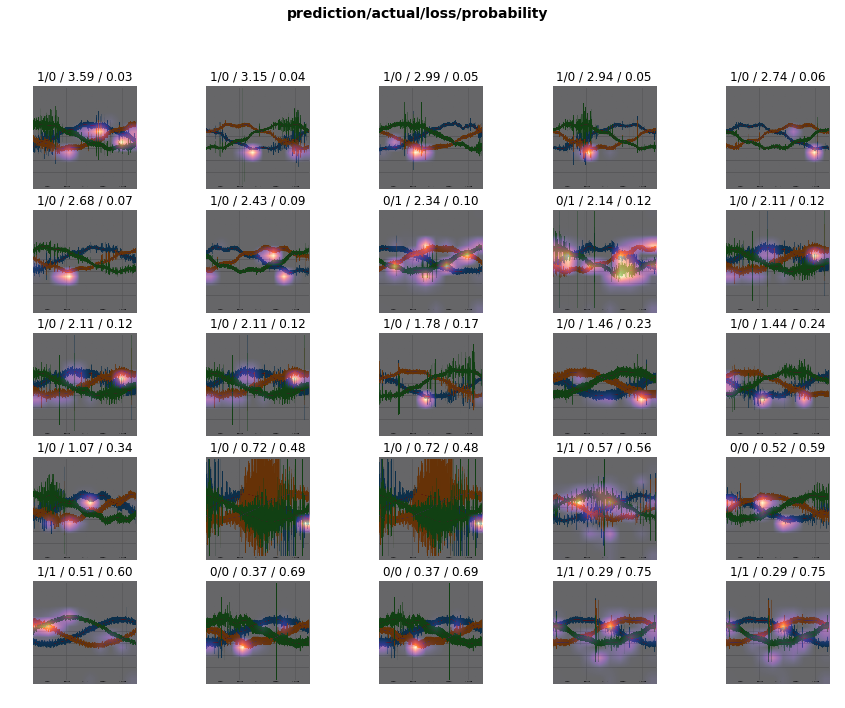

In [33]:
# We can see what is interesting
interp.plot_top_losses(25, figsize=(15,11))

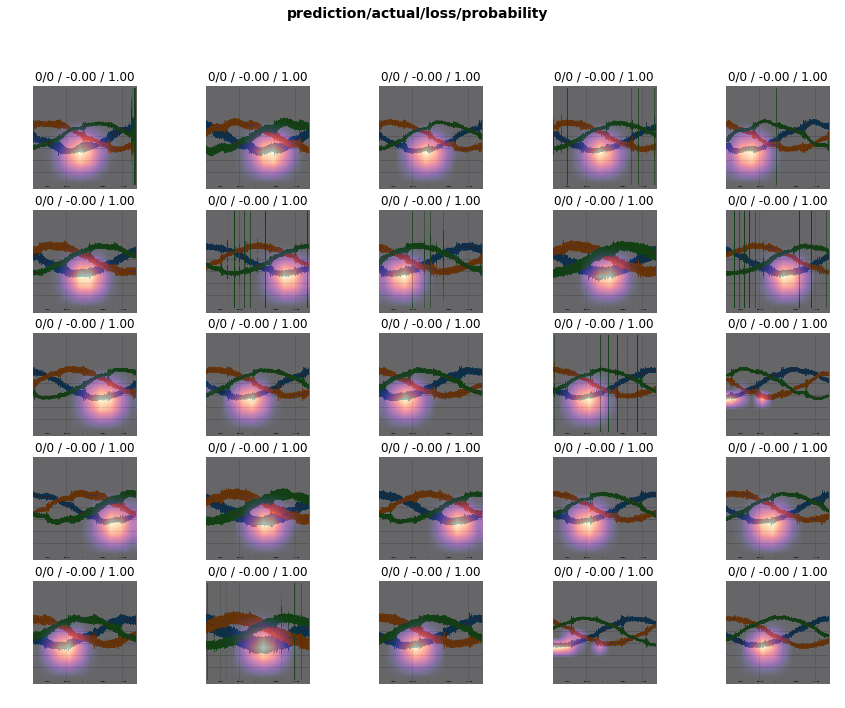

In [34]:
# just wanted to see the items we got right
interp.plot_top_losses(25, largest=False, figsize=(15,11))

# Exporting

In [35]:
# Sending out the predictions for everything
test_df = testlabels.pop('image')

In [36]:
testlabels['image']= test_df

In [37]:
len(testlabels)

20337

In [38]:
#preds = learn.get_preds(ds_type=DatasetType.Test)
preds = learn.get_preds(ds_type=DatasetType.Test)

In [39]:
preds[0][:,0]

tensor([0.9999, 1.0000, 0.6000,  ..., 0.9780, 0.9998, 0.9974])

In [40]:
target_preds=preds[0][:,1]
len(target_preds)

6779

In [41]:
target_preds=target_preds.tolist()

### Predictions for Kaggle

In [42]:
img = learn.data.train_ds[0][0]
learn.predict(img)

(Category 0, tensor(0), tensor([0.9982, 0.0018]))

In [43]:
# basically expand out the items from our 1 image to predictions for multiple signals
b=[]
for x in target_preds:
    if (x>.5):
        i=1
    else:
        i=0
    b.append(i)
    b.append(i)
    b.append(i)
    
target_preds=b

In [44]:
# sets it for our tables
testlabels['target']=target_preds

In [45]:
# Always nice to see what we are submitting
testlabels['target'].agg(['min', 'max', 'mean', 'std']).round(decimals=2)

min     0.00
max     1.00
mean    0.03
std     0.16
Name: target, dtype: float64

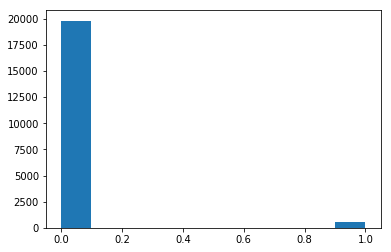

In [47]:
# Check if the outputs are going to make sense. They do here.
import numpy as np
import matplotlib.pyplot as plt
mu, sigma = 200, 25
x = testlabels['target']
n, bins, patches = plt.hist(x)
plt.show()

In [48]:
# shows a few labels taht will be submitted
testlabels[['signal_id','target']][286:300]

,signal_id,target
286,8998,0
287,8999,0
288,9000,0
289,9001,0
290,9002,0
291,9003,0
292,9004,0
293,9005,0
294,9006,0
295,9007,0


In [50]:
testlabels.to_csv('/home/jd/data/vsb/submit/submission.csv', columns=['signal_id', 'target'], index=False)
print("http://localhost:8888/view/data/vsb/submit/submission.csv")

http://localhost:8888/view/data/vsb/submit/submission.csv
